# prediction of a mortgage approval 
----
the data is from Federal Financial Institutions Examination Council's (FFIEC)

In [1]:
from sklearn.metrics import roc_auc_score,accuracy_score
import os
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer as Imputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# path to the data
path="data/"

In [3]:
# functions to load the data
def load_input_features(path=path):
    data=f"{path}train_values.csv"
    return pd.read_csv(data)

def load_target_variable(path=path):
    data=os.path.join(path,"train_labels.csv")
    return pd.read_csv(data)
input_set=load_input_features()
target=load_target_variable()

In [4]:
# shape of the input features
input_set.shape

(500000, 22)

from the shape of the input_features the data has 500000 observations with 22 features

the target variable consist of two classes 0 and 1 indicating whether a mortgage application was denied or accepted 

In [5]:
target.accepted.value_counts()

1    250114
0    249886
Name: accepted, dtype: int64

In [6]:
# percentage of each class within the data
(target.accepted.value_counts()/len(target))*100

1    50.0228
0    49.9772
Name: accepted, dtype: float64

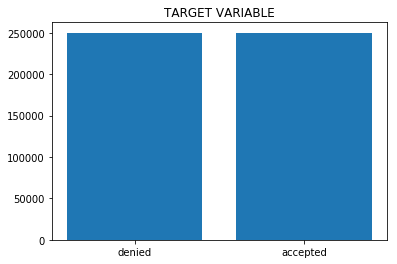

In [7]:
Names=['denied','accepted']
def plot_target_classes(names=None,data=None):
    plt.bar(names,data)
    plt.title('TARGET VARIABLE')
    plt.show()
    
plot_target_classes(names=Names,data=target.accepted.value_counts())  

the number of accepted (1) and denied (0) classes of the target variable seems to be almost the same 
and this tends to shows a balanced data

In [8]:
# concatenating the target variable to the input features
input_set['accepted']=target.accepted

# Visualizing class separation by categorical features
---
creating Bar charts of the label classes for the categorical features. The proportion of the categories
for each of the label values were compared to determine the usefulness of the features. If these
proportions are distinctly different for each label category, then that feature is likely to be a useful in
predicting mortgage approval or denied.


• Loan purpose, property type, preapproval and applicant race have significantly different distribution of
categories between the label classes and seems to be useful features.
• Features such as co applicant, applicant ethnicity, loan type and occupancy show small differences
• Applicant sex seems to have almost the same value for each label category and seems not to be a
useful feature for predicting mortgage approval hence was dropped

In [9]:
train_set=input_set
train_set.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner_occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,0,3,1,1,1,70,3,18,37,246,...,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False,1
1,1,1,1,3,1,178,3,369,52,299,...,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False,0
2,2,2,1,3,1,163,3,16,10,306,...,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,False,1
3,3,1,1,1,1,155,1,305,47,180,...,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,True,1
4,4,1,1,1,1,305,3,24,37,20,...,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,False,1


# Visualizing class separation by categorical features

In [10]:
train_set.preapproval.value_counts()/len(train_set)

3    0.822218
2    0.120286
1    0.057496
Name: preapproval, dtype: float64

property_type


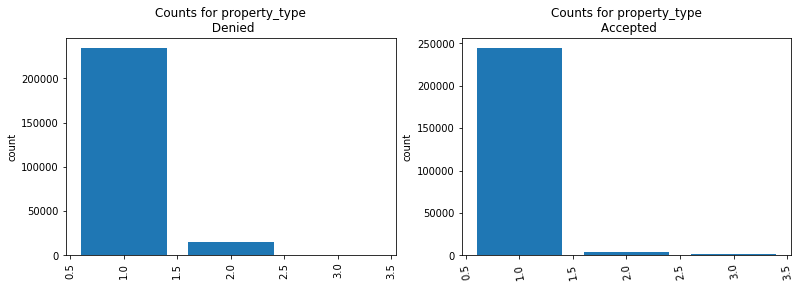

applicant_race


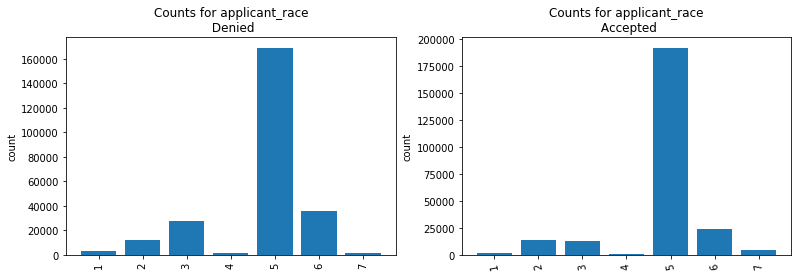

co_applicant


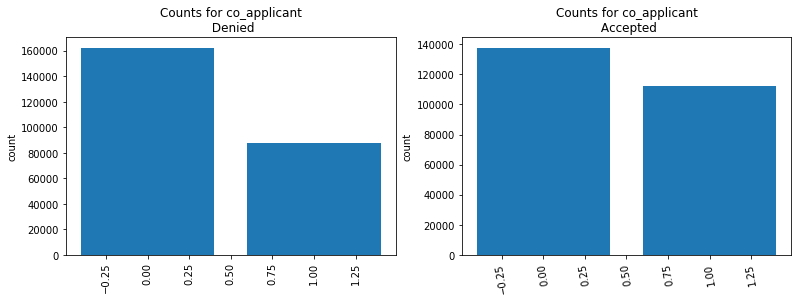

preapproval


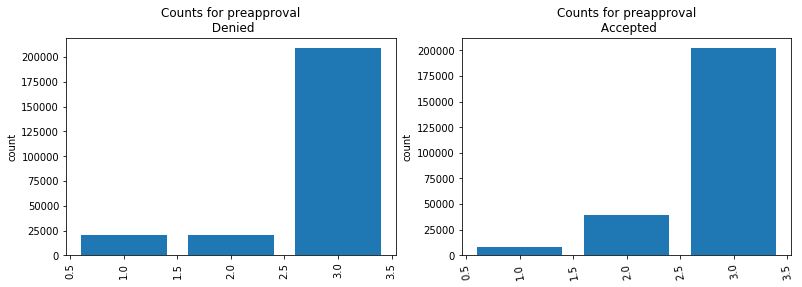

occupancy


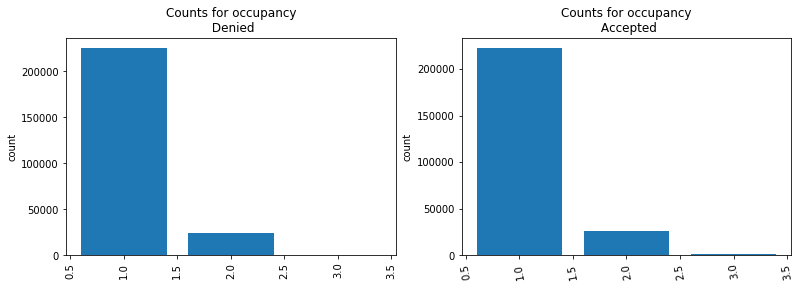

loan_type


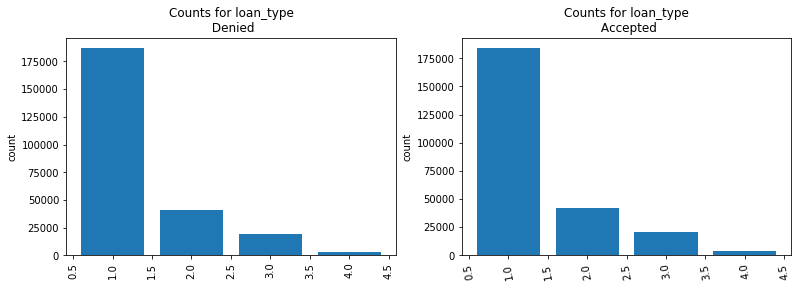

applicant_sex


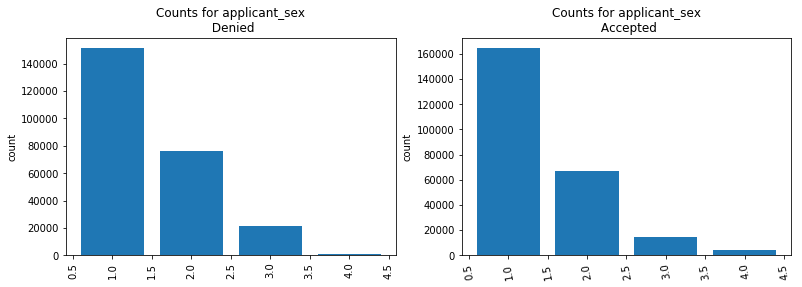

applicant_ethnicity


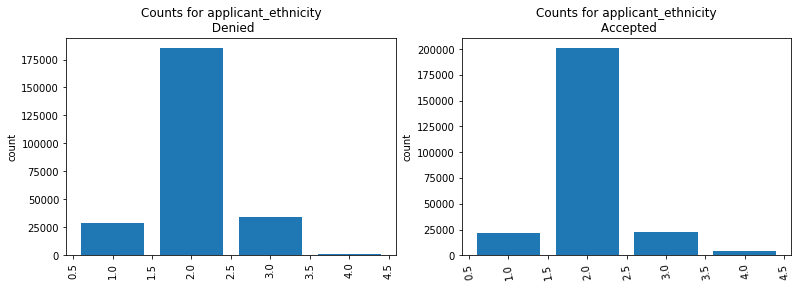

loan_purpose


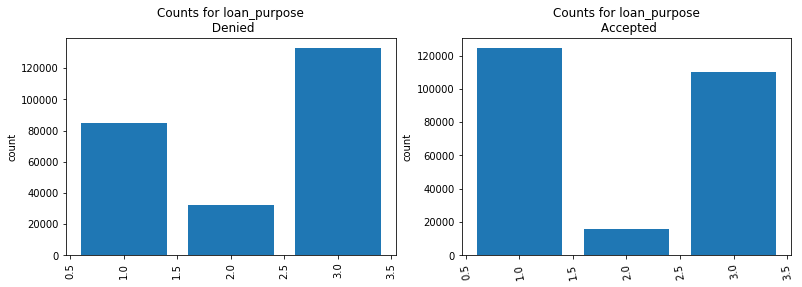

In [11]:
cat_cols = ['property_type','applicant_race','co_applicant','preapproval','occupancy','loan_type','applicant_sex',
            'applicant_ethnicity','loan_purpose'
           ]

input_set['dummy'] = np.ones(shape = input_set.shape[0])
for col in cat_cols:
    print(col)
    counts = input_set[['dummy', 'accepted', col]].groupby(['accepted', col], as_index = False).count()
    temp = counts[counts['accepted'] == 0][[col, 'dummy']]
    _ = plt.figure(figsize = (13,4))
    plt.subplot(1, 2, 1)
    temp = counts[counts['accepted'] == 0][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n Denied')
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    temp = counts[counts['accepted'] == 1][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks(rotation=100)
    plt.title('Counts for ' + col + '\n Accepted')
    plt.ylabel('count')
    plt.show()

In [12]:
train_set.drop(["dummy"],axis=1,inplace=True)

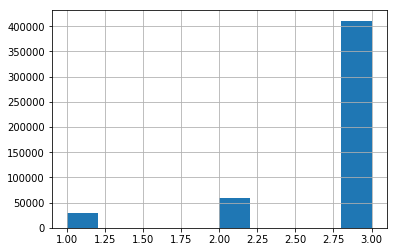

In [13]:
train_set.preapproval.hist()

preapproval is highly imbalance so we will combine 1 and 2

In [14]:
cylinder_categories = {1:1, 2:1, 3:2}
train_set['preapprova'] = [cylinder_categories[x] for x in train_set['preapproval']]
train_set['preapprova'].value_counts()
train_set.drop(['preapproval'],axis=1,inplace=True)


In [15]:
train_set.rename(columns={'preapprova':'preapproval'},inplace=True)

In [16]:
train_set.preapproval.value_counts()/len(train_set)

2    0.822218
1    0.177782
Name: preapproval, dtype: float64

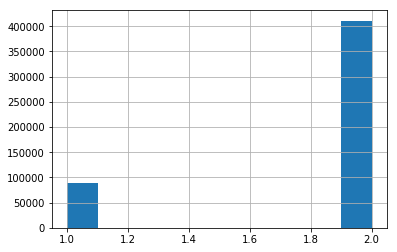

In [17]:
train_set.preapproval.hist()

In [18]:
train_set.applicant_sex.value_counts()

1    315806
2    142876
3     35643
4      5675
Name: applicant_sex, dtype: int64

In [19]:
cy = {1:1, 2:2, 3:3,4:3}
train_set['applicant_sexx'] = [cy[x] for x in train_set['applicant_sex']]
train_set['applicant_sexx'].value_counts()

1    315806
2    142876
3     41318
Name: applicant_sexx, dtype: int64

In [20]:
train_set.drop(['applicant_sex'],axis=1,inplace=True)

In [21]:
train_set.rename(columns={'applicant_sexx':'applicant_sex'},inplace=True)

In [22]:
train_set.applicant_sex.value_counts()

1    315806
2    142876
3     41318
Name: applicant_sex, dtype: int64

In [23]:
train_set.applicant_ethnicity.value_counts()

2    386061
3     57298
1     50822
4      5819
Name: applicant_ethnicity, dtype: int64

In [24]:
cyy = {1:1, 2:2, 3:1,4:1}
train_set['applicant_ethnicityy'] = [cyy[x] for x in train_set['applicant_ethnicity']]
train_set.drop(['applicant_ethnicity'],axis=1,inplace=True)
train_set.rename(columns={'applicant_ethnicityy':'applicant_ethnicity'},inplace=True)
train_set.applicant_ethnicity.value_counts()

2    386061
1    113939
Name: applicant_ethnicity, dtype: int64

In [25]:
train_set.applicant_race.value_counts()

5    361538
6     59862
3     40495
2     25756
7      5678
1      4332
4      2339
Name: applicant_race, dtype: int64

In [26]:
cyy = {1:1, 2:1, 3:1,4:1,5:2,6:1,7:1}
train_set['applicant_racee'] = [cyy[x] for x in train_set['applicant_race']]
train_set.drop(['applicant_race'],axis=1,inplace=True)
train_set.rename(columns={'applicant_racee':'applicant_race'},inplace=True)
train_set['applicant_race'].value_counts()

2    361538
1    138462
Name: applicant_race, dtype: int64

In [27]:
train_set.loan_type.value_counts()

1    370827
2     82430
3     39521
4      7222
Name: loan_type, dtype: int64

In [28]:
cyyy = {1:1, 2:2, 3:2,4:2}
train_set['loan_typee'] = [cyyy[x] for x in train_set['loan_type']]
train_set.drop(['loan_type'],axis=1,inplace=True)
train_set.rename(columns={'loan_typee':'loan_type'},inplace=True)
train_set['loan_type'].value_counts()

1    370827
2    129173
Name: loan_type, dtype: int64

In [29]:
train_set.property_type.value_counts()

1    478217
2     19741
3      2042
Name: property_type, dtype: int64

In [30]:
cyyy = {1:1, 2:2, 3:2}
train_set['property_typee'] = [cyyy[x] for x in train_set['property_type']]
train_set.drop(['property_type'],axis=1,inplace=True)
train_set.rename(columns={'property_typee':'property_type'},inplace=True)


In [31]:
train_set.head()

,row_id,loan_purpose,occupancy,loan_amount,msa_md,state_code,county_code,applicant_income,population,minority_population_pct,...,number_of_1_to_4_family_units,lender,co_applicant,accepted,preapproval,applicant_sex,applicant_ethnicity,applicant_race,loan_type,property_type
0,0,1,1,70,18,37,246,24.0,6203.0,44.230,...,2642.0,4536,False,1,2,1,2,2,2,1
1,1,3,1,178,369,52,299,57.0,5774.0,15.905,...,2108.0,2458,False,0,2,1,1,2,1,1
2,2,3,1,163,16,10,306,67.0,6094.0,61.270,...,1048.0,5710,False,1,2,1,2,2,2,1
3,3,1,1,155,305,47,180,105.0,6667.0,6.246,...,2299.0,5888,True,1,1,1,2,2,1,1
4,4,1,1,305,24,37,20,71.0,6732.0,100.000,...,1847.0,289,False,1,2,2,2,1,1,1


In [32]:
train_set.drop(['row_id'],axis=1,inplace=True)

In [33]:
train_set.co_applicant.value_counts()

False    299974
True     200026
Name: co_applicant, dtype: int64

In [34]:
def Binarizer(data=None,col=None):
    binarizer=LabelBinarizer()
    feature=binarizer.fit_transform(data[col])
    feature=pd.DataFrame(feature,columns=[col])
    data.drop([col],axis=1,inplace=True)
    data[col]=feature

In [35]:
Binarizer(train_set,col='co_applicant')

In [36]:
train_set.co_applicant.value_counts()

0    299974
1    200026
Name: co_applicant, dtype: int64

In [37]:
# the number of missing values in each column
train_set.isnull().sum()

loan_purpose                          0
occupancy                             0
loan_amount                           0
msa_md                                0
state_code                            0
county_code                           0
applicant_income                  39948
population                        22465
minority_population_pct           22466
ffiecmedian_family_income         22440
tract_to_msa_md_income_pct        22514
number_of_owner_occupied_units    22565
number_of_1_to_4_family_units     22530
lender                                0
accepted                              0
preapproval                           0
applicant_sex                         0
applicant_ethnicity                   0
applicant_race                        0
loan_type                             0
property_type                         0
co_applicant                          0
dtype: int64

In [38]:
train_set.shape

(500000, 22)

In [39]:
# the percentage of missing values in each column
for i in train_set.isnull().sum()/len(train_set):
    if i!=0:
        print(np.round(i,5)*100)

7.99
4.492999999999999
4.492999999999999
4.488
4.503
4.513
4.506


In [40]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
loan_purpose                      500000 non-null int64
occupancy                         500000 non-null int64
loan_amount                       500000 non-null int64
msa_md                            500000 non-null int64
state_code                        500000 non-null int64
county_code                       500000 non-null int64
applicant_income                  460052 non-null float64
population                        477535 non-null float64
minority_population_pct           477534 non-null float64
ffiecmedian_family_income         477560 non-null float64
tract_to_msa_md_income_pct        477486 non-null float64
number_of_owner_occupied_units    477435 non-null float64
number_of_1_to_4_family_units     477470 non-null float64
lender                            500000 non-null int64
accepted                          500000 non-null int64
preapproval                       5

In [41]:
def fill_num_missing(data,cols=None):
    # columns with missing values
    missing_data=data[cols]
    # first creat imputer object
    imputer=Imputer(missing_values=np.nan, strategy='mean')
    data_df=imputer.fit_transform(missing_data)
    data_df=pd.DataFrame(data_df, columns=missing_data.columns)
    data[cols]=data_df
    

In [42]:
num=["applicant_income","population","minority_population_pct","ffiecmedian_family_income","tract_to_msa_md_income_pct",
         "number_of_owner_occupied_units","number_of_1_to_4_family_units"]
fill_num_missing(train_set,cols=num)

In [43]:
train_set.isnull().sum()

loan_purpose                      0
occupancy                         0
loan_amount                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner_occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
accepted                          0
preapproval                       0
applicant_sex                     0
applicant_ethnicity               0
applicant_race                    0
loan_type                         0
property_type                     0
co_applicant                      0
dtype: int64

In [44]:
train_set.shape

(500000, 22)

In [45]:
train_set.head(2)

,loan_purpose,occupancy,loan_amount,msa_md,state_code,county_code,applicant_income,population,minority_population_pct,ffiecmedian_family_income,...,number_of_1_to_4_family_units,lender,accepted,preapproval,applicant_sex,applicant_ethnicity,applicant_race,loan_type,property_type,co_applicant
0,1,1,70,18,37,246,24.0,6203.0,44.230,60588.0,...,2642.0,4536,1,2,1,2,2,2,1,0
1,3,1,178,369,52,299,57.0,5774.0,15.905,54821.0,...,2108.0,2458,0,2,1,1,2,1,1,0


In [46]:
# rearranging the columns so that the target variable will be the last column
cols=[col for col in train_set if col != 'accepted']+['accepted']
train_set=train_set[cols]

In [47]:
train_set.head(2)

,loan_purpose,occupancy,loan_amount,msa_md,state_code,county_code,applicant_income,population,minority_population_pct,ffiecmedian_family_income,...,number_of_1_to_4_family_units,lender,preapproval,applicant_sex,applicant_ethnicity,applicant_race,loan_type,property_type,co_applicant,accepted
0,1,1,70,18,37,246,24.0,6203.0,44.230,60588.0,...,2642.0,4536,2,1,2,2,2,1,0,1
1,3,1,178,369,52,299,57.0,5774.0,15.905,54821.0,...,2108.0,2458,2,1,1,2,1,1,0,0


In [48]:
train_set.shape

(500000, 22)

In [49]:
train_set.drop(['population'],axis=1,inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [50]:
Featuress=train_set.iloc[:,:-1].values
labelss=train_set.iloc[:,-1].values

In [51]:
from sklearn.model_selection import train_test_split
np.random.seed(9988)
indx = range(Featuress.shape[0])
indx = train_test_split(indx, test_size = .3)
X_train = Featuress[indx[0],:]
y_train = np.ravel(labelss[indx[0]])
X_test = Featuress[indx[1],:]
y_test = np.ravel(labelss[indx[1]])

In [52]:
xgbd=XGBClassifier(n_estimators=100,criterion='entropy', max_delta_step=6,min_samples_split=45,colsample_bytree=.4,
                  max_depth=13,max_features=11,min_child_weight=.4,gama=10)
xgbd.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, criterion='entropy',
              gama=10, gamma=0, learning_rate=0.1, max_delta_step=6,
              max_depth=13, max_features=11, min_child_weight=0.4,
              min_samples_split=45, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [53]:
y_predict  = xgbd.predict(X_test)
accuracy_score(y_test,y_predict)

0.7169333333333333

In [54]:
ttt=train_set
ttt.drop(['accepted'],axis=1,inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


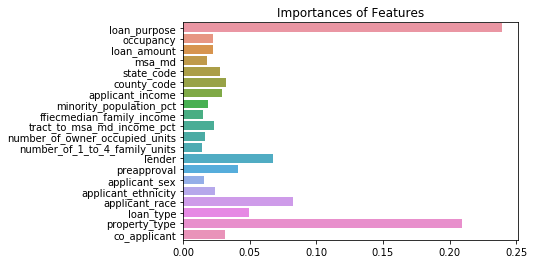

In [55]:


fea=pd.Series(xgbd.feature_importances_,index=ttt.columns)
plt.title('Importances of Features')
sns.barplot(x=fea,y=fea.index)
plt.show()

In [56]:
import sklearn.metrics as sklm
def print_metrics(y_test,pred_cv):
    metrics = sklm.precision_recall_fscore_support(y_test,y_predict)
    conf = sklm.confusion_matrix(y_test,y_predict)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.4f' % sklm.accuracy_score(y_test,y_predict))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test,y_predict)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive     49047             26128
Actual negative     16332             58493

Accuracy  0.7169
 
           Positive      Negative
Num case    75175         74825
Precision    0.75          0.69
Recall       0.65          0.78
F1           0.70          0.73


[Text(0,0.5,'actual positive'), Text(0,1.5,'actual negative')]

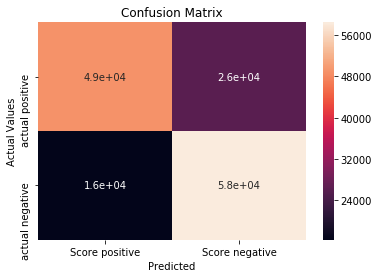

In [57]:
conf_mat = sklm.confusion_matrix(y_test,y_predict)
ax=plt.subplot()
# annot : write the data value in each cell.
# ax :  Axes in which to draw the plot
sns.heatmap(conf_mat,annot=True,ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual Values')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(['Score positive','Score negative'])
ax.set_yticklabels(['actual positive','actual negative'])


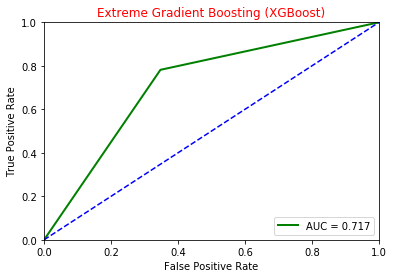

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_test,y_predict)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2,color = 'green' ,label = 'AUC = %0.3f' % auc(fpr, tpr))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], 'b--')
    plt.axis([0, 1, 0, 1])
    plt.title('Extreme Gradient Boosting (XGBoost)',color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [59]:
import pickle
from sklearn.externals import joblib

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [60]:
# saving the model
filename='mortgage_model.pkl'
joblib.dump(xgbd,filename)

['mortgage_model.pkl']

In [61]:
# loading the saved model
model=joblib.load('mortgage_model.pkl')
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, criterion='entropy',
              gama=10, gamma=0, learning_rate=0.1, max_delta_step=6,
              max_depth=13, max_features=11, min_child_weight=0.4,
              min_samples_split=45, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [62]:
# path to the data
path="data/"
# functions to load the data
def load_test_input_features(path=path):
    data=f"{path}test_values.csv"
    return pd.read_csv(data)
test_set=load_test_input_features()
# shape of the input features
test_set.shape

(500000, 22)

In [63]:
test_set.head(2)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,2,1,3,1,115.0,3,101,16,276,...,1,NaN,6329.0,59.536,69889.0,85.78,1874.0,2410.0,3791,True
1,1,1,1,1,1,252.0,2,87,20,68,...,1,107.0,2473.0,8.050,65313.0,100.00,947.0,1214.0,2839,True


In [64]:

cylinder_categories = {1:1, 2:1, 3:2}
test_set['preapprova'] = [cylinder_categories[x] for x in test_set['preapproval']]
test_set.drop(['preapproval'],axis=1,inplace=True)
test_set.rename(columns={'preapprova':'preapproval'},inplace=True)

cy = {1:1, 2:2, 3:3,4:3}
test_set['applicant_sexx'] = [cy[x] for x in test_set['applicant_sex']]
test_set.drop(['applicant_sex'],axis=1,inplace=True)
test_set.rename(columns={'applicant_sexx':'applicant_sex'},inplace=True)

cyy = {1:1, 2:2, 3:1,4:1}
test_set['applicant_ethnicityy'] = [cyy[x] for x in test_set['applicant_ethnicity']]
test_set.drop(['applicant_ethnicity'],axis=1,inplace=True)
test_set.rename(columns={'applicant_ethnicityy':'applicant_ethnicity'},inplace=True)

cyy = {1:1, 2:1, 3:1,4:1,5:2,6:1,7:1}
test_set['applicant_racee'] = [cyy[x] for x in test_set['applicant_race']]
test_set.drop(['applicant_race'],axis=1,inplace=True)
test_set.rename(columns={'applicant_racee':'applicant_race'},inplace=True)

cyyy = {1:1, 2:2, 3:2,4:2}
test_set['loan_typee'] = [cyyy[x] for x in test_set['loan_type']]
test_set.drop(['loan_type'],axis=1,inplace=True)
test_set.rename(columns={'loan_typee':'loan_type'},inplace=True)

cyyy = {1:1, 2:2, 3:2}
test_set['property_typee'] = [cyyy[x] for x in test_set['property_type']]
test_set.drop(['property_type'],axis=1,inplace=True)
test_set.rename(columns={'property_typee':'property_type'},inplace=True)

def Binarizer(data=None,col=None):
    binarizer=LabelBinarizer()
    feature=binarizer.fit_transform(data[col])
    feature=pd.DataFrame(feature,columns=[col])
    data.drop([col],axis=1,inplace=True)
    data[col]=feature
    
Binarizer(test_set,col='co_applicant')

def fill_num_missing(data,cols=None):
    # columns with missing values
    missing_data=data[cols]
    # first creat imputer object
    imputer=Imputer(missing_values=np.nan, strategy='mean')
    data_df=imputer.fit_transform(missing_data)
    data_df=pd.DataFrame(data_df, columns=missing_data.columns)
    data[cols]=data_df


In [65]:
test_set.drop(['row_id'],axis=1,inplace=True)

In [66]:
test_set.rename({"number_of_owner-occupied_units":"number_of_owner_occupied_units"},axis=1,inplace=True)

In [67]:
    
num=["applicant_income","population","minority_population_pct","ffiecmedian_family_income","tract_to_msa_md_income_pct",
         "number_of_owner_occupied_units","number_of_1_to_4_family_units"]
fill_num_missing(test_set,cols=num)

In [68]:
test_set.head(3)

,loan_purpose,occupancy,loan_amount,msa_md,state_code,county_code,applicant_income,population,minority_population_pct,ffiecmedian_family_income,...,number_of_owner_occupied_units,number_of_1_to_4_family_units,lender,preapproval,applicant_sex,applicant_ethnicity,applicant_race,loan_type,property_type,co_applicant
0,3,1,115.0,101,16,276,101.926536,6329.000000,59.536000,69889.000000,...,1874.000000,2410.000000,3791,2,1,2,2,2,1,1
1,1,1,252.0,87,20,68,107.000000,2473.000000,8.050000,65313.000000,...,947.000000,1214.000000,2839,1,1,2,2,1,1,1
2,1,1,270.0,-1,-1,-1,119.000000,5411.205196,31.631572,69254.074141,...,1426.559815,1884.863422,4701,1,2,2,1,1,1,0


In [69]:
test_set.columns

Index(['loan_purpose', 'occupancy', 'loan_amount', 'msa_md', 'state_code',
       'county_code', 'applicant_income', 'population',
       'minority_population_pct', 'ffiecmedian_family_income',
       'tract_to_msa_md_income_pct', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units', 'lender', 'preapproval',
       'applicant_sex', 'applicant_ethnicity', 'applicant_race', 'loan_type',
       'property_type', 'co_applicant'],
      dtype='object')

In [70]:
test_set.co_applicant.value_counts()

0    300168
1    199832
Name: co_applicant, dtype: int64

In [71]:
test_set.lender.head()

0    3791
1    2839
2    4701
3    2153
4    5710
Name: lender, dtype: int64

In [72]:
test_set.shape

(500000, 21)

In [73]:
test_set.drop(['population'],axis=1,inplace=True)

In [74]:
test_set.head()

,loan_purpose,occupancy,loan_amount,msa_md,state_code,county_code,applicant_income,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner_occupied_units,number_of_1_to_4_family_units,lender,preapproval,applicant_sex,applicant_ethnicity,applicant_race,loan_type,property_type,co_applicant
0,3,1,115.0,101,16,276,101.926536,59.536000,69889.000000,85.780000,1874.000000,2410.000000,3791,2,1,2,2,2,1,1
1,1,1,252.0,87,20,68,107.000000,8.050000,65313.000000,100.000000,947.000000,1214.000000,2839,1,1,2,2,1,1,1
2,1,1,270.0,-1,-1,-1,119.000000,31.631572,69254.074141,91.813397,1426.559815,1884.863422,4701,1,2,2,1,1,1,0
3,1,1,179.0,376,20,11,44.000000,29.676000,57766.000000,100.000000,1426.000000,1765.000000,2153,1,2,2,1,2,1,1
4,1,1,36.0,254,48,156,32.000000,5.110000,63332.000000,100.000000,1452.000000,2092.000000,5710,1,3,1,1,2,1,0


In [75]:
test_set=test_set.iloc[:,:].values

In [76]:
test_set[1]

array([1.0000e+00, 1.0000e+00, 2.5200e+02, 8.7000e+01, 2.0000e+01,
       6.8000e+01, 1.0700e+02, 8.0500e+00, 6.5313e+04, 1.0000e+02,
       9.4700e+02, 1.2140e+03, 2.8390e+03, 1.0000e+00, 1.0000e+00,
       2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00])

In [77]:
test_pred=model.predict(test_set)

In [78]:
test_pred=pd.DataFrame(test_pred,columns=['Status'])

In [79]:
test_pred.head()

,Status
0,1
1,1
2,0
3,1
4,0


In [167]:
test_pred.replace({1:'accepted',0:'denied'},inplace=True)

In [168]:
test_pred.head()

,Status
0,accepted
1,accepted
2,denied
3,accepted
4,denied


In [1]:
import pandas as pd

In [18]:
aa=pd.DataFrame({"A":[1],"B":[2],"C":[3],"D":[4]})
aa

,A,B,C,D
0,1,2,3,4


In [19]:
aa.iloc[:,:].values

array([[1, 2, 3, 4]], dtype=int64)

In [10]:
c=[1,2,3]
import numpy as np
c=np.array(c)

array([1, 2, 3])

In [11]:
import pandas as pd

In [13]:
d=pd.DataFrame(c,columns=['A'])

In [15]:
d.iloc[:,:].values

array([[1],
       [2],
       [3]], dtype=int64)

In [3]:
c=np.array(c)
c

array([1, 2, 3, 3])

In [4]:
c.shape

(4,)

In [8]:
c=c.reshape(1,-1)
c.shape

(1, 4)

In [9]:
c.replace({1:'accepted',0:'denied'},inplace=True)

array([[1, 2, 3, 3]])

In [18]:
g='gg'
print('id {}'.format(g))

id gg
